<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/My\ Drive/Colab\ Notebooks/
!ls
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from idlmam  import *

Mounted at /content/drive
drive  sample_data


/content/drive/My Drive/Colab Notebooks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import unicodedata
import string
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim


In [5]:
pip install datasets


In [11]:
import shutil
import os

cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Cache cleared.")


In [12]:
from datasets import load_dataset
dataset = load_dataset("go_emotions", download_mode="force_redownload")

# Check the dataset structure
print(dataset)
label_mapping = dataset["train"].features["labels"].feature.names


ConnectionError: Couldn't reach 'go_emotions' on the Hub (LocalEntryNotFoundError)

In [10]:
emotion_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
  alphabet[all_letters[i]] = i


def unicodeToAscii(s):
    # Turns a Unicode string into plain ASCII
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

for sample in dataset["train"]:
    text = sample["text"]  # The text sample
    labels = sample["labels"]  # The list of labels for this sample

    # Normalize the text using the unicodeToAscii function
    normalized_text = unicodeToAscii(text).lower()

    # Loop through all labels for this sample (in case there are multiple labels)
    for label in labels:
        emotion = label_mapping[label]  # Map label index to emotion name

        # Add to the emotion_data dictionary
        if emotion not in emotion_data:
            emotion_data[emotion] = []  # Initialize the list for this emotion
        emotion_data[emotion].append(normalized_text)

# Print out the emotion names and their respective text count
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")

NameError: name 'dataset' is not defined

In [6]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
      self.label_names = [x for x in lang_name_dict.keys()]
      self.data = []
      self.labels = []
      self.vocabulary = vocabulary
      for y, language in enumerate(self.label_names):
          for sample in lang_name_dict[language]:
              if len(sample) > 0:  # Filter out empty inputs
                  self.data.append(sample)
                  self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """

        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [7]:
dataset = LanguageNameDataset(emotion_data, alphabet)

# Limit the dataset size to 20,000 samples
total_size = min(len(dataset), 30000)  # Use the smaller of the dataset size or 20,000

# Define proportions
train_ratio = 0.8  # 80% training
test_ratio = 0.2   # 20% testing

# Compute split sizes
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Take a subset of the dataset if the dataset is larger than 20,000
subset_indices = torch.randperm(len(dataset))[:total_size]  # Randomly select 20,000 indices
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

# Randomly split the subset dataset
train_data, test_data = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [8]:
import torch
import torch.nn as nn

def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)

    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [9]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects.
    This wrapper class will fix that. If a normal input comes in, it will
    use the regular Embedding layer. Otherwise, it will work on the packed
    sequence to return a new Packed sequence of the appropriate result.
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input,
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(),
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


In [11]:
dataset = LanguageNameDataset(emotion_data, alphabet)

# Limit the dataset size to 20,000 samples
total_size = min(len(dataset), 20000)  # Use the smaller of the dataset size or 20,000

# Define proportions
train_ratio = 0.8  # 80% training
test_ratio = 0.2   # 20% testing

# Compute split sizes
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Take a subset of the dataset if the dataset is larger than 20,000
subset_indices = torch.randperm(len(dataset))[:total_size]  # Randomly select 20,000 indices
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

# Randomly split the subset dataset
train_data, test_data = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [12]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple,
            last_step = last_step[0]#then h_t is the first item in the tuple

        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import time


def visualize2DSoftmax(X, y, model):
    """Function to visualize the classification boundary of a learned model on a 2-D dataset

    Arguments:
    X -- a numpy array of shape (2, N), where N is the number of data points.
    y -- a numpy array of shape (N,), which contains values of either "0" or "1" for two different classes
    model -- a PyTorch Module object that represents a classifer to visualize. s
    """
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        preds = model(torch.tensor(xy_v, dtype=torch.float32))
        preds = F.softmax(preds, dim=1).numpy()

    cs = plt.contourf(xv, yv, preds[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=cs.ax)

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class DebugShape(nn.Module):
    """
    Module that is useful to help debug your neural network architecture.
    Insert this module between layers and it will print out the shape of
    that layer.
    """
    def forward(self, input):
        print(input.shape)
        return input

def weight_reset(m):
    """
    Go through a PyTorch module m and reset all the weights to an initial random state
    """
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None,
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use.
    optimizer -- the method used to alter the gradients for learning.

    """
    if score_funcs == None:
        score_funcs = {}#Empty set

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []


    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )


        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()

        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")


        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

### RNN utility Classes

class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'

        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects.
    This wrapper class will fix that. If a normal input comes in, it will
    use the regular Embedding layer. Otherwise, it will work on the packed
    sequence to return a new Packed sequence of the appropriate result.
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input,
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(),
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)



### Attention Mechanism Layers

class ApplyAttention(nn.Module):
    """
    This helper module is used to apply the results of an attention mechanism toa set of inputs.
    """

    def __init__(self):
        super(ApplyAttention, self).__init__()

    def forward(self, states, attention_scores, mask=None):
        """
        states: (B, T, H) shape giving the T different possible inputs
        attention_scores: (B, T, 1) score for each item at each context
        mask: None if all items are present. Else a boolean tensor of shape
            (B, T), with `True` indicating which items are present / valid.

        returns: a tuple with two tensors. The first tensor is the final context
        from applying the attention to the states (B, H) shape. The second tensor
        is the weights for each state with shape (B, T, 1).
        """

        if mask is not None:
            #set everything not present to a large negative value that will cause vanishing gradients
            attention_scores[~mask] = -1000.0
        #compute the weight for each score
        weights = F.softmax(attention_scores, dim=1) #(B, T, 1) still, but sum(T) = 1

        final_context = (states*weights).sum(dim=1) #(B, T, D) * (B, T, 1) -> (B, D)
        return final_context, weights

class AttentionAvg(nn.Module):

    def __init__(self, attnScore):
        super(AttentionAvg, self).__init__()
        self.score = attnScore

    def forward(self, states, context, mask=None):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, D), a weighted av

        """

        B = states.size(0)
        T = states.size(1)
        D = states.size(2)

        scores = self.score(states, context) #(B, T, 1)

        if mask is not None:
            scores[~mask] = float(-10000)
        weights = F.softmax(scores, dim=1) #(B, T, 1) still, but sum(T) = 1

        context = (states*weights).sum(dim=1) #(B, T, D) * (B, T, 1) -> (B, D, 1)


        return context.view(B, D) #Flatten this out to (B, D)


class AdditiveAttentionScore(nn.Module):

    def __init__(self, D):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(D, 1)
        self.w = nn.Linear(2*D, D)

    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D

        """
        T = states.size(1)
        #Repeating the values T times
        context = torch.stack([context for _ in range(T)], dim=1) #(B, D) -> (B, T, D)
        state_context_combined = torch.cat((states, context), dim=2) #(B, T, D) + (B, T, D)  -> (B, T, 2*D)
        scores = self.v(torch.tanh(self.w(state_context_combined)))
        return scores

class GeneralScore(nn.Module):

    def __init__(self, D):
        super(GeneralScore, self).__init__()
        self.w = nn.Bilinear(D, D, 1)

    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D

        """
        T = states.size(1)
        D = states.size(2)
        #Repeating the values T times
        context = torch.stack([context for _ in range(T)], dim=1) #(B, D) -> (B, T, D)
        scores = self.w(states, context) #(B, T, D) -> (B, T, 1)
        return scores

class DotScore(nn.Module):

    def __init__(self, D):
        super(DotScore, self).__init__()

    def forward(self, states, context):
        """
        states: (B, T, D) shape
        context: (B, D) shape
        output: (B, T, 1), giving a score to each of the T items based on the context D

        """
        T = states.size(1)
        D = states.size(2)

        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(D) #(B, T, D) -> (B, T, 1)
        return scores

def getMaskByFill(x, time_dimension=1, fill=0):
    """
    x: the original input with three or more dimensions, (B, ..., T, ...)
        which may have unsued items in the tensor. B is the batch size,
        and T is the time dimension.
    time_dimension: the axis in the tensor `x` that denotes the time dimension
    fill: the constant used to denote that an item in the tensor is not in use,
        and should be masked out (`False` in the mask).

    return: A boolean tensor of shape (B, T), where `True` indicates the value
        at that time is good to use, and `False` that it is not.
    """
    to_sum_over = list(range(1,len(x.shape))) #skip the first dimension 0 because that is the batch dimension

    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)

    with torch.no_grad():
        #Special case is when shape is (B, D), then it is an embedding layer. We just return the values that are good
        if len(to_sum_over) == 0:
            return (x != fill)
        #(x!=fill) determines locations that might be unused, beause they are
        #missing the fill value we are looking for to indicate lack of use.
        #We then count the number of non-fill values over everything in that
        #time slot (reducing changes the shape to (B, T)). If any one entry
        #is non equal to this value, the item represent must be in use -
        #so return a value of true.
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched

In [13]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)


torch.Size([5]) torch.Size([5, 2])
tensor([[-1.2949, -2.5662],
        [-0.0086,  1.5356],
        [-0.0086,  1.5356],
        [-1.2949, -2.5662],
        [ 2.0602, -0.7500]])


In [14]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)


In [18]:
from torch.utils.data import DataLoader

dataset = LanguageNameDataset(emotion_data, alphabet)
classes = len(dataset.label_names)
device = 'cpu'
loss_func = nn.CrossEntropyLoss()
from sklearn.metrics import accuracy_score



B = 30
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_packed.to(device)





Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=28, bias=True)
)

In [ ]:
rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

optimizer = optim.Adam(rnn_3layer.parameters(), lr=0.001)  # Lower lr for stability
rnn_3layer.to(device)

rnn_3layer_results = train_network(
    rnn_3layer,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=10,
    optimizer=optimizer
)



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/534 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

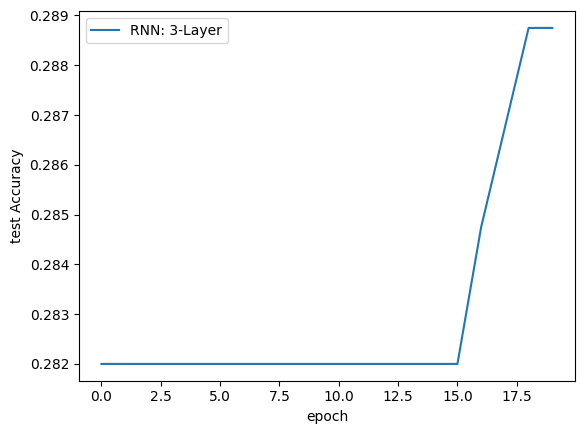

In [21]:

sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results,
label='RNN: 3-Layer')
